In [1]:
!pip install pretty_midi
!pip install gdown
!pip install miditok
!pip install midi-clip

!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

!wget https://raw.githubusercontent.com/roostico/NesGen/refs/heads/main/utility.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.5 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=7c607f8c8f68b0c4457764719700bdc2a6b26e798cc710cc014b680cfb05f419
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.5 MB/s eta 0:00:0000:01
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 l

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import glob

import os
import random
import shutil
from pathlib import Path
import pretty_midi
import numpy as np
from miditok import REMI, TokenizerConfig
import json
from miditok.utils import split_files_for_training
from miditok.data_augmentation import augment_dataset
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
import pickle

from IPython import display


_SAMPLING_RATE = 16000

def display_audio(file, seconds=30):
  pm = pretty_midi.PrettyMIDI(file)
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)
     

In [5]:
# Get Maestro Dataset
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "/kaggle/working/maestro-v3.0.0"

--2024-12-27 09:22:19--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.135.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M  89.2MB/s    in 0.6s    

2024-12-27 09:22:20 (89.2 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]

Archive:  maestro-v3.0.0-midi.zip
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Tra

In [6]:
# Paths to the files of the dataset

midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + list(Path(dataset_path).resolve().glob("**/*.midi"))

midis_dir = "midis"
os.makedirs(midis_dir, exist_ok=True)


for i, midi_path in enumerate(midi_paths):
  new_midi_path = os.path.join(midis_dir, f"{i}.midi")
  shutil.move(str(midi_path), new_midi_path)


midis = list(Path("/kaggle/working/midis").resolve().glob("**/*.mid")) + list(Path("/kaggle/working/midis").resolve().glob("**/*.midi"))

def sample():
  return str(random.choice(midis))

In [7]:
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}

TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": BEAT_RES,
    "num_velocities": 3,
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),  # (min_tempo, max_tempo),
}

config = TokenizerConfig(**TOKENIZER_PARAMS)

tokenizer = REMI(config)

In [8]:
vocab_size = 5000
tokenizer.train(vocab_size=vocab_size, files_paths=midis)
processed = [Path(f"{s}") for s in midis]
print(len(processed))

valid_perc = 0.05
augment = True

total_num_files = len(processed)
num_files_valid = round(total_num_files * valid_perc)
shuffle(processed)
midi_paths_valid = processed[:num_files_valid]
midi_paths_train = processed[num_files_valid:]

# Chunk MIDIs and perform data augmentation on each subset independently

for files_paths, subset_name in (
    (midi_paths_train, "train"),
    (midi_paths_valid, "valid"),
):
    print(files_paths[0])

    # Split the MIDIs into chunks of sizes approximately about 1024 tokens

    subset_chunks_dir = Path(f"Maestro_{subset_name}")

    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

    # Perform data augmentation
    if augment:
        augment_dataset(
            subset_chunks_dir,
            pitch_offsets=[-12, 12],
            velocity_offsets=[-3, 3],
            duration_offsets=[-0.5, 0.5],
        )

midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
midi_paths_valid = list(Path("Maestro_valid").glob("**/*.mid")) + list(Path("Maestro_valid").glob("**/*.midi"))

1276
/kaggle/working/midis/578.midi


Performing data augmentation: 100%|██████████| 11503/11503 [00:30<00:00, 373.97it/s]


/kaggle/working/midis/571.midi


Performing data augmentation: 100%|██████████| 716/716 [00:02<00:00, 355.12it/s]


In [9]:
def midi_valid(midi) -> bool:

    if any(ts.numerator != 4 for ts in midi.time_signature_changes):

        return False  # time signature different from 4/*, 4 beats per bar

    return True



if os.path.exists("tokenized"):

  shutil.rmtree("tokenized")


for dir in ("train", "valid"):
    tokenizer.tokenize_dataset(        
    
        Path(f"/kaggle/working/Maestro_{dir}"),
        Path(f"/kaggle/working/tokenized_{dir}"),
        midi_valid,
    
    )

Tokenizing music files (working/tokenized_valid): 100%|██████████| 4299/4299 [01:46<00:00, 40.39it/s]


In [10]:
def read_json(path: str) -> dict:

  with open(path, "r") as f:

    return json.load(f)

def read_json_files(json_file_paths):
    """Reads a list of JSON files and returns a list of objects.
    Args:
        json_file_paths: A list of file paths to JSON files.
    Returns:
        A list of objects, where each object represents the data from a JSON file.
        Returns an empty list if any error occurs during file processing.
    """

    objects = []

    for file_path in tqdm(json_file_paths):

        try:

            objects.append(read_json(file_path))

        except FileNotFoundError:

            print(f"Error: File not found - {file_path}")

            return [] # Return empty list on error

        except json.JSONDecodeError:

            print(f"Error decoding JSON in file: {file_path}")

            return [] # Return empty list on error

    return objects

In [11]:
tokenized_train = list(Path("tokenized_train").resolve().glob("**/*.json"))
data_objects_train = read_json_files(tokenized_train)

tokenized_valid = list(Path("tokenized_valid").resolve().glob("**/*.json"))
data_objects_valid = read_json_files(tokenized_valid)

if data_objects_train:
    print(f"\nSuccessfully read {len(data_objects_train)} training JSON files.")
else:
    print("Error reading JSON files.")

100%|██████████| 4299/4299 [00:00<00:00, 6767.58it/s]


Successfully read 68872 training JSON files.


In [12]:
encoded_train = [np.array(song["ids"][0]) for song in data_objects_train]
encoded_valid = [np.array(song["ids"][0]) for song in data_objects_valid]

In [13]:
# tokenizer.decode([encoded_train[0][:1024]]).dump_midi("sample.mid")
all_ids_train = np.concatenate(encoded_train)
all_ids_valid = np.concatenate(encoded_valid)
import datetime
today = datetime.datetime.today()
day = today.day
month = today.month
name = "tokenizer{:d}_{:02d}{:02d}.json".format(vocab_size, month, day)
tokenizer.save(name)
np.savetxt("ids_train_{:02d}{:02d}.txt".format(month, day), all_ids_train)
np.savetxt("ids_valid_{:02d}{:02d}.txt".format(month, day), all_ids_valid)
all_ids_train = all_ids_train.astype(dtype=np.int32)
all_ids_valid = all_ids_valid.astype(dtype=np.int32)

In [3]:
# if you need to skip all
#!gdown 1FqWFCW5TjWTI8rrbBy5uwYjS3GYl9MWF # tokenizer1000_1219.json
#!gdown 1Xs-5FenAaUJE_WipUDIFfQ4lFrK8VHve # ids_train_1219.txt

#tokenizer = REMI(params="tokenizer1000_1219.json")
#all_ids_train = np.loadtxt("ids_train_1219.txt").astype(dtype=np.int32)
#all_ids_valid = np.loadtxt("ids_valid_1217.txt").astype(dtype=np.int32)

Downloading...
From (original): https://drive.google.com/uc?id=1PrRtOtvx5DUoEsxqpsp83kv9dsmceMfe
From (redirected): https://drive.google.com/uc?id=1PrRtOtvx5DUoEsxqpsp83kv9dsmceMfe&confirm=t&uuid=68aab8b2-71ad-4ed6-982e-57d3c34b854b
To: /kaggle/working/ids_train_1216.txt
100%|███████████████████████████████████████| 1.40G/1.40G [00:12<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=13LQTCuBSn6BOKXGnoiUVCY5eO0BBCnF_
To: /kaggle/working/tokenizer5000_1216.json
100%|█████████████████████████████████████████| 263k/263k [00:00<00:00, 109MB/s]


Exception: data did not match any variant of untagged enum ModelWrapper at line 1 column 126362

# Model 

## Generator (choose one)

In [14]:
class GenFC1(nn.Module):
    def __init__(self,noise_dim, hidden_dim, seq_length, num_layers, n_features = 1, drop_rate = 0.3):
        """
        PyTorch implementation of the Generator model.

        Args:
            noise_dim (int): Size of the input noise vector.
            seq_length (int): Length of the output sequence.
            n_features (int): Number of features per timestep in the output.
            drop_rate (float): Dropout rate.
        """
        super(GenFC1, self).__init__()
        self.noise_dim = noise_dim
        self.seq_length = seq_length
        self.n_features = n_features

        self.fc1 = nn.Linear(noise_dim, 1024)
        self.lrelu1 = nn.LeakyReLU(0.3)
        self.bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 1024)
        self.lrelu2 = nn.LeakyReLU(0.2)
        self.bn2 = nn.BatchNorm1d(1024, momentum=0.8)
        self.dropout = nn.Dropout(drop_rate)

        self.fc3 = nn.Linear(1024, seq_length * n_features)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward pass of the Generator.

        Args:
            x (torch.Tensor): Input noise vector of shape (batch_size, noise_dim).

        Returns:
            torch.Tensor: Output sequence of shape (batch_size, seq_length, n_features).
        """
        x = x.squeeze(-1)
        x = self.fc1(x)
        x = self.lrelu1(x)
        x = self.bn1(x)

        x = self.fc2(x)
        x = self.lrelu2(x)
        x = self.bn2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.tanh(x)
        x = x.view(-1, self.seq_length, self.n_features)  # Reshape to (batch_size, seq_length, n_features)
        return x


class GenFC2(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length, num_layers, n_features=1, drop_rate=0.3):
        super(GenFC2, self).__init__()
        self.noise_dim = noise_dim
        self.seq_length = seq_length
        self.n_features = n_features
        self.num_layers = num_layers

        # Fully connected layers before LSTM
        self.fc1 = nn.Linear(noise_dim, hidden_dim)
        self.lrelu1 = nn.LeakyReLU(0.3)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.lrelu2 = nn.LeakyReLU(0.3)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # Reshaping to be fed into the LSTM
        self.fc3 = nn.Linear(hidden_dim, seq_length * n_features)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc4 = nn.Linear(hidden_dim, n_features)  # Output layer
        #self.fc4 = nn.Linear(seq_length * n_features, seq_length * n_features)  # Output layer
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.squeeze(-1)
        # x: Input noise vector of shape (batch_size, noise_dim)
        x = self.fc1(x)
        x = self.lrelu1(x)
        x = self.bn1(x)

        x = self.fc2(x)
        x = self.lrelu2(x)
        x = self.bn2(x)

        # Ensure the output is reshaped correctly
        x = self.fc3(x)
        x = x.view(-1, self.seq_length, self.n_features)  # Reshape for LSTM

        # Feed through the LSTM
        x, _ = self.lstm(x)

        # Optionally, apply an additional fully connected layer after LSTM
        x = self.fc4(x)
        x = x.view(-1, self.seq_length, self.n_features)
        x = self.tanh(x)
        return x

class GenLSTM1(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length, num_layers):
        super(GenLSTM1, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.noise_dim = noise_dim
        
        # The linear layer should map the noise to (batch_size, hidden_dim * seq_length)
        self.fc = nn.Linear(noise_dim, hidden_dim * seq_length)  # Map noise to the size that works with LSTM
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.output_fc = nn.Linear(hidden_dim, 1)  # Output layer for each time step
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.squeeze(-1)  # Remove the last dimension -> (batch_size, noise_dim)
        x = self.fc(x)  # Map noise to (batch_size, hidden_dim * seq_length)
        x = x.view(-1, self.seq_length, self.hidden_dim)  # Reshape to (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x)  # Pass through LSTM
        out = self.output_fc(out)  # Map hidden states to output dimension
        return self.tanh(out)  # Shape: (batch_size, seq_length, 1)

class GenLSTM2(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length, num_layers, drop_rate=0.3):
        super(GenLSTM2, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(drop_rate)

        # Time-distributed layers
        self.fc1 = nn.Linear(hidden_dim, seq_length)
        self.bn1 = nn.BatchNorm1d(noise_dim)
        self.lrelu1 = nn.ReLU(inplace=True)
        

        self.fc2 = nn.Linear(seq_length, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward pass of the Generator.

        Args:
            x (torch.Tensor): Input noise of shape (batch_size, latent_dim, 1).

        Returns:
            torch.Tensor: Output sequence of shape (batch_size, latent_dim, output_dim).
        """
        # Pass through LSTM
        x, _ = self.lstm(x)

        # Apply dropout
        x = self.dropout(x)

        # Time-distributed dense layers
        x = self.fc1(x)
        x = self.lrelu1(x)
        #x = self.bn1(x.transpose(1, 2)).transpose(1, 2)  # BatchNorm applied along the feature axis

        x = self.fc2(x)  # Final output layer
        return self.tanh(x)


class GenTransformer(nn.Module):
    def __init__(self, noise_dim, seq_length, d_model, nhead, num_layers, vocab_size, dropout=0.1):
        super(GenTransformer, self).__init__()
        self.noise_dim = noise_dim
        self.seq_length = seq_length
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embedding layer for noise input
        self.embedding = nn.Linear(noise_dim, d_model)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))

        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout),
            num_layers=num_layers
        )

        # Output layer
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, noise):
        # Embed and add positional encoding
        x = self.embedding(noise) + self.positional_encoding[:, :noise.size(1), :]
        # Pass through the transformer
        x = self.transformer(x)
        # Map to output logits (vocab_size)
        return torch.log_softmax(self.output_layer(x), dim=-1)  # Logits for vocab_size

class GenFC3(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length):
        super(GenFC3, self).__init__()
        
        # We use fully connected layers instead of ConvTranspose2d
        self.fc1 = nn.Linear(noise_dim, hidden_dim * 4)  # First layer expands noise to a larger hidden space
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)  # Reducing dimensionality
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)  # Further reducing dimensionality
        self.fc4 = nn.Linear(hidden_dim, seq_length)  # Final output layer to produce sequence
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Output will be of shape (batch_size, seq_length)
        return x


class GenFC4(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length):
        super(GenFC4, self).__init__()
        
        # Deeper and larger network
        self.fc1 = nn.Linear(noise_dim, hidden_dim * 16)  # Increase hidden dimension size
        self.fc2 = nn.Linear(hidden_dim * 16, hidden_dim * 8)
        self.fc3 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, seq_length)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)  # Final output layer
        return torch.tanh(x)

## Discriminator (choose one)

In [15]:
# Discriminator
class DiscFC1(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(DiscFC1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.main(x)


class DiscFC2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(DiscFC2, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # First fully connected block
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Adding more fully connected layers with residual connections
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        self.fc3 = nn.Linear(hidden_dim, 256)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        
        # Output layer
        self.fc4 = nn.Linear(256, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        
        # First fully connected block with LeakyReLU and BatchNorm
        x = self.fc1(x)
        x = self.lrelu1(x)
        x = self.bn1(x)
        
        # Second fully connected block with LeakyReLU and BatchNorm
        for _ in range(self.num_layers):
            residual = x  # Store input for residual connection
            x = self.fc2(x)
            x = self.lrelu2(x)
            x = self.bn2(x)
            
            # Add residual connection
            x = x + residual
        
        # Third fully connected layer with LeakyReLU
        x = self.fc3(x)
        x = self.lrelu3(x)
        
        # Optional dropout for regularization
        x = self.dropout(x)
        
        # Final output layer
        x = self.fc4(x)

        return x

class DiscLSTM1(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(DiscLSTM1, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Predict a single scalar for real/fake
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)  # Pass through LSTM
        out = out[:, -1, :]  # Use the last time step's hidden state: (batch_size, hidden_dim)
        out = self.fc(out)  # Map to a single value: (batch_size, 1) 
        return out  # Real/fake probability

class DiscLSTM2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(DiscLSTM2, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.leaky_relu2 = nn.LeakyReLU(0.3)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM expects input as (batch_size, seq_len, input_dim)
        _, (h_n, _) = self.lstm(x)  # Only use the last hidden state (h_n)
        x = h_n[-1]  # h_n contains layers, take the last layer's output
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.fc3(x)
        #x = self.sigmoid(x)
        return x


class DiscCNN(nn.Module):
    def __init__(self, seq_length, vocab_size, embed_dim=128, num_filters=64, dropout=0.3):
        super(DiscCNN, self).__init__()
        self.seq_length = seq_length
        self.vocab_size = vocab_size

        # Embedding layer for token IDs
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Use 1D convolutions for sequence data
        self.conv1 = nn.Conv1d(embed_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(num_filters * 2, num_filters * 4, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc = nn.Linear(seq_length * num_filters * 4, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input shape: (batch_size, seq_length)
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embed_dim)
        x = x.permute(0, 2, 1)  # Switch to (batch_size, embed_dim, seq_length) for Conv1d
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.dropout(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return torch.sigmoid(self.fc(x))  # Single output for real/fake classification

class DiscFC3(nn.Module):
    def __init__(self, seq_length, hidden_dim):
        super(DiscFC3, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(seq_length, hidden_dim)  # First layer to map input to hidden space
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # Reducing dimensionality
        self.fc3 = nn.Linear(hidden_dim // 2, 1)  # Final layer to output a scalar (real/fake)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # First layer activation
        x = torch.relu(self.fc2(x))  # Second layer activation
        x = torch.sigmoid(self.fc3(x))  # Output a probability between 0 and 1 (real or fake)
        return x

class DiscFC4(nn.Module):
    def __init__(self, seq_length, hidden_dim):
        super(DiscFC4, self).__init__()
        
        # More powerful and deeper network
        self.fc1 = nn.Linear(seq_length, hidden_dim * 2)  # Larger first layer
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc3 = nn.Linear(hidden_dim * 4, hidden_dim * 8)
        self.fc4 = nn.Linear(hidden_dim * 8, hidden_dim * 16)
        self.fc5 = nn.Linear(hidden_dim * 16, 1)  # Final output layer

        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.2)
        
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))  # Leaky ReLU for better gradient flow
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.dropout(self.leaky_relu(self.fc3(x)))
        x = self.dropout(self.leaky_relu(self.fc4(x)))
        #x = torch.sigmoid(self.fc5(x))  # Output a probability between 0 and 1
        x = self.fc5(x)
        #x = torch.clamp(x, min=-10, max=10)  # Clamp outputs
        return x

# Hyper-parameters and models

In [16]:
def get_model(name: str, config: dict):
    if name == "gen_fc1":
        return GenFC1(**config)
    elif name == "gen_fc2":
        return GenFC2(**config)
    elif name == "gen_fc3":
        return GenFC3(**config)
    elif name == "gen_fc4":
        return GenFC4(**config)
    elif name == "gen_lstm1":
        return GenLSTM1(**config)
    elif name == "gen_lstm2": 
        return GenLSTM2(**config)
    elif name == "gen_transformer": 
        return GenTransformer(**config)
    elif name == "disc_fc1":
        return DiscFC1(**config)
    elif name == "disc_fc2":
        return DiscFC2(**config)
    elif name == "disc_fc3":
        return DiscFC3(**config)
    elif name == "disc_fc4":
        return DiscFC4(**config)
    elif name == "disc_lstm1":
        return DiscLSTM1(**config)
    elif name == "disc_lstm2":
        return DiscLSTM2(**config)
    elif name == "disc_cnn":
        return DiscCNN(**config)
    else:
        raise KeyError("Unknown model")

vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
batch_size = 128

#generator_config = {
#    "noise_dim"  : noise_dim,
#    "seq_length" : seq_length,
#    "d_model"    : 512,
#    "nhead"      : 8,
#    "num_layers" : 6,
#    "vocab_size" : vocab_size,
#}

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : 1536,
    "seq_length" : seq_length
}

#discriminator_config = {
#    "seq_length" : seq_length,
#    "vocab_size" : vocab_size,
#}

discriminator_config = {
    "seq_length" : seq_length,
    "hidden_dim" : 1536
}

generator = get_model("gen_fc4", generator_config)
discriminator = get_model("disc_fc4", discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "seq_length"               : seq_length,
    "tokenizer"                : tokenizer,
}

## GAN class 

In [17]:
class GAN:
    def __init__(self, 
                 generator, 
                 discriminator, 
                 noise_dim,
                 seq_length,
                 tokenizer,
                 loss = nn.BCEWithLogitsLoss(),
                ):
        self.G = generator
        self.D = discriminator
        self.noise_dim = noise_dim
        self.seq_length = seq_length
        self.loss = loss
        
        self.optimizer_G = torch.optim.Adam(self.G.parameters(), lr=0.00005, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.D.parameters(), lr=0.00005, betas=(0.5, 0.999))
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        # Apply Xavier initialization for Linear layers
        def init_weights(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
        
        # Initialize all layers
        self.G.apply(init_weights)
        self.D.apply(init_weights)

        #self.G.apply(self._weights_init)
        #self.D.apply(self._weights_init)
        
    def _weights_init(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    def noise(self, size, device):
        return torch.randn(size, self.noise_dim, device=device)

    def _G_train_step(self, batch_size, device):
        self.G.zero_grad()

        # Generate fake data
        fake_noise = self.noise(batch_size, device)
        fake_data = self.G(fake_noise)
    
        # Discriminator prediction on fake data
        fake_preds = self.D(fake_data)
    
        epsilon = 1e-8
        loss_G = -torch.mean(fake_preds)  # WGAN Loss
    
        # Check for NaNs and clip gradients
        if torch.isnan(loss_G).any() or torch.isinf(loss_G).any():
            print(f"NaN or Inf detected in G Loss")
        else:
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(self.G.parameters(), max_norm=1.0)
            self.optimizer_G.step()
    
        return loss_G

    def _D_train_step(self, batch_size, real_data, device):
        self.D.zero_grad()
    
        fake_noise = self.noise(batch_size, device)
        fake_data = self.G(fake_noise)
        #print(f"Fake data in D step {fake_data}")
        #print(f"Real data in D step {real_data}")
        
        real_preds = self.D(real_data) 
        fake_preds = self.D(fake_data) 
        #print(f"Real Preds in D step {real_preds}")
        #print(f"Fake Preds in D step {torch.mean(fake_preds)}")

        real_labels = torch.ones_like(real_preds)
        fake_labels = torch.zeros_like(fake_preds)
        
        loss_real = self.loss(real_preds, real_labels)
        loss_fake = self.loss(fake_preds, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        #torch.nn.utils.clip_grad_norm_(self.D.parameters(), max_norm=1.0)
        self.optimizer_D.step()
        
        if torch.isnan(loss_D).any() or torch.isinf(loss_D).any():
            print(f"NaN or Inf detected in D Loss")

        return loss_D

    def _train_step(self, batch_size, real_data, device, gen_steps=1, disc_steps=1):
        losses_D = []
        losses_G = []
        for i in range(disc_steps):
            losses_D.append(self._D_train_step(batch_size, real_data, device))
        for i in range(gen_steps):
            losses_G.append(self._G_train_step(batch_size, device))
        return (losses_D, losses_G)
        

    def train(
        self, 
        dataloader, 
        epochs, 
        device,  
        loss_delta=0.7,
        steps_each_print=5,
        advantage_steps=2,
        alternate_training=False,
        gen_steps=1,
        disc_steps=1,
    ):
        print(f"Starting training with {epochs} epochs")
        self.G = self.G.to(device)
        self.D = self.D.to(device)
        self.G.train(True)
        self.D.train(True)
        
        iteration_count = len(dataloader)  # Number of batches per epoch
        batch_size = dataloader.batch_size

        disc_steps = disc_steps
        gen_steps = gen_steps

        final_losses_D = []
        final_losses_G = []
        
        for epoch in range(epochs):  
            pbar = tqdm(total=iteration_count, position=0, leave=True)
            for step, real_data in enumerate(dataloader):
                batch_size = real_data.size(0)
                real_data = real_data.to(device)
                
                losses_D, losses_G = self._train_step(batch_size, real_data, device, gen_steps, disc_steps)
                losses_D = [loss.cpu().item() for loss in losses_D]  # Convert each loss to a scalar
                losses_G = [loss.cpu().item() for loss in losses_G]
                loss_D, loss_G = (np.mean(losses_D), np.mean(losses_G))
                final_losses_D.append(loss_D)
                final_losses_G.append(loss_G)

                if alternate_training:
                    if loss_G - loss_D > loss_delta:
                        gen_steps = advantage_steps
                        disc_steps = 1
                    elif loss_D - loss_G  > loss_delta:
                        disc_steps = advantage_steps
                        gen_steps = 1
                    else:
                        gen_steps = 1
                        disc_steps = 1
                
                if (step + 1) % steps_each_print == 0:
                    description = f"D Loss: {loss_D:.4f}, G Loss: {loss_G:.4f}" 
                    if gen_steps != 1 or disc_steps != 1:
                        description = description + f", D Steps: {disc_steps}, G Steps: {gen_steps}"
                    pbar.set_description(description)
                    pbar.update(steps_each_print)
            pbar.n = pbar.total  
            pbar.refresh()    
            pbar.close()
        
            print(f'Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')
            #self.generate_and_show(2, f"epoch_{epoch}_gen", device)
            
        return final_losses_D, final_losses_G

    def save_generator(self, directory):
        torch.save(self.G, directory)

    def predict(self, n, device):
        z = self.noise(n, device)# Rumore casuale
        return self.G(z).cpu().detach().numpy()
    
    def generate(self, n, base_output_name, device):
        normalized_predictions = self.predict(n, device)
        boundary = int(len(tokenizer) / 2)
        predictions = [x * boundary + boundary for x in normalized_predictions]
        for i in range(len(predictions)):
            pred = predictions[i]                                # [[5.0], [6.0], [7.0]]
            pred_tokens = pred.astype(np.int32)                  # [5, 6, 7]
            pred_tokens[pred_tokens == len(tokenizer)] = 0       # if some value equals vocab_size, replace with empty tokens 
            try:
                decoded = tokenizer.decode([pred_tokens])
                decoded.dump_midi(f"{base_output_name}_{i}.mid")
            except Exception as e:
                print(e)
            
            
    def generate_and_show(self, n, base_output_name, device):
        name = f"{base_output_name}_0.mid"
        self.generate(n, base_output_name, device)
        display_audio(name)


gan = GAN(**gan_params)

# Training

## Prepare data 

In [18]:
# Dataset personalizzato
class TokenDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

vocab_size = len(tokenizer)

def normalize_data(data, vocab_size, interval=(-1, 1)):
    """
    Normalize data to a specified interval (default: [-1, 1]).
    - data: The data to normalize (e.g., token IDs or other numeric values).
    - vocab_size: The range of the data (e.g., the vocabulary size for token IDs).
    - interval: The target interval for normalization as a tuple (min, max).
    
    Returns:
    - Normalized data in the specified interval.
    """
    # Extract interval boundaries
    min_val, max_val = interval
    
    # Center the data around 0 and scale to [-1, 1]
    normalized_data = (data - vocab_size / 2) / (vocab_size / 2)
    
    # Scale to the target interval
    scaled_data = normalized_data * (max_val - min_val) / 2 + (max_val + min_val) / 2
    
    return scaled_data
    
normalized_seq = normalize_data(all_ids_train, vocab_size)
#normalized_seq = all_ids_train
print(f"Max is {normalized_seq.max()}, Min is {normalized_seq.min()}")

# Suddivisione in sequenze
all_ids_train_seq = [normalized_seq[i:i + seq_length] 
                 for i in range(0, len(normalized_seq) - seq_length, seq_length)]

dataset = TokenDataset(all_ids_train_seq)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
_ = torch.ones(1, device='cuda')  # Dummy operation to initialize CUDA

Max is 0.9996, Min is -0.9988


## Start the training

In [19]:
# Training loop
training_arguments = {
    "dataloader"         : dataloader,
    "epochs"             : 50,
    "device"             : device,
    "steps_each_print"   : 10,
    "gen_steps"          : 1,
    "disc_steps"         : 1,
    #"alternate_training" : True,
    #"loss_delta"         : 1.0,
    #"advantage_steps"    : 2,
}

losses_D, losses_G = gan.train(**training_arguments)

Starting training with 50 epochs


D Loss: 0.5984, G Loss: 2.6818: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [1/50] Loss D: 0.7622, Loss G: 0.6918


D Loss: 0.4700, G Loss: 3.4135: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [2/50] Loss D: 0.1604, Loss G: 3.9304


D Loss: 1.4177, G Loss: -0.0366: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [3/50] Loss D: 1.4041, Loss G: 0.0746


D Loss: 1.4074, G Loss: -0.0023: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [4/50] Loss D: 1.3883, Loss G: 0.1567


D Loss: 1.4085, G Loss: -0.0748: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [5/50] Loss D: 1.3902, Loss G: -0.0699


D Loss: 0.6622, G Loss: 2.2217: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [6/50] Loss D: 0.5523, Loss G: 0.3722


D Loss: 1.3849, G Loss: 0.0040: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [7/50] Loss D: 1.3995, Loss G: -0.1070


D Loss: 1.3652, G Loss: 0.1761: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [8/50] Loss D: 1.4339, Loss G: -0.0903


D Loss: 1.3846, G Loss: 0.0507: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [9/50] Loss D: 1.3892, Loss G: -0.0091


D Loss: 0.3481, G Loss: 5.2150: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [10/50] Loss D: 0.2316, Loss G: 4.3078


D Loss: 0.8545, G Loss: 1.3671: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [11/50] Loss D: 0.7809, Loss G: 1.8631


D Loss: 0.6475, G Loss: 1.9638: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [12/50] Loss D: 1.4278, Loss G: 4.8780


D Loss: 1.1500, G Loss: 1.5318: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [13/50] Loss D: 1.0768, Loss G: 1.5130


D Loss: 1.0032, G Loss: 2.3515: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [14/50] Loss D: 1.1919, Loss G: 0.9610


D Loss: 1.2107, G Loss: 1.0572: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [15/50] Loss D: 1.1955, Loss G: 1.1433


D Loss: 1.1653, G Loss: 0.4538: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [16/50] Loss D: 1.2562, Loss G: 1.1275


D Loss: 1.2905, G Loss: 0.5448: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [17/50] Loss D: 1.5029, Loss G: 0.1861


D Loss: 1.1544, G Loss: 2.3527: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [18/50] Loss D: 1.1468, Loss G: 1.1833


D Loss: 1.2934, G Loss: 0.6150: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [19/50] Loss D: 1.1981, Loss G: 0.7968


D Loss: 1.3908, G Loss: 0.2937: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [20/50] Loss D: 1.3321, Loss G: 0.3502


D Loss: 1.2697, G Loss: 0.5011: 100%|██████████| 1066/1066 [07:02<00:00,  2.53it/s]


Epoch [21/50] Loss D: 1.2953, Loss G: 0.4914


D Loss: 1.3106, G Loss: 0.3412: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [22/50] Loss D: 1.3318, Loss G: 0.2598


D Loss: 1.2932, G Loss: 0.3982: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [23/50] Loss D: 1.3441, Loss G: 0.4159


D Loss: 1.7141, G Loss: 0.9675: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [24/50] Loss D: 1.3750, Loss G: 0.1754


D Loss: 1.4259, G Loss: -0.0800: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [25/50] Loss D: 1.3921, Loss G: 0.1031


D Loss: 1.2892, G Loss: 0.1610: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [26/50] Loss D: 1.2109, Loss G: 0.5031


D Loss: 1.2831, G Loss: 0.4142: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [27/50] Loss D: 1.3441, Loss G: 0.3398


D Loss: 1.2907, G Loss: 0.2401: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [28/50] Loss D: 1.2646, Loss G: 0.7836


D Loss: 1.3256, G Loss: 0.2187: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [29/50] Loss D: 1.3961, Loss G: 0.0239


D Loss: 1.3644, G Loss: 0.1297: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [30/50] Loss D: 1.3921, Loss G: -0.0173


D Loss: 1.3672, G Loss: -0.0306: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [31/50] Loss D: 1.4484, Loss G: -0.0533


D Loss: 1.4179, G Loss: 0.1075: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [32/50] Loss D: 1.3918, Loss G: 0.0021


D Loss: 1.3950, G Loss: 0.0303: 100%|██████████| 1066/1066 [07:01<00:00,  2.53it/s]


Epoch [33/50] Loss D: 1.4036, Loss G: 0.0054


D Loss: 1.3565, G Loss: 0.1562: 100%|██████████| 1066/1066 [07:02<00:00,  2.53it/s]


Epoch [34/50] Loss D: 1.3717, Loss G: 0.3402


D Loss: 1.4075, G Loss: 0.1051: 100%|██████████| 1066/1066 [07:02<00:00,  2.53it/s] 


Epoch [35/50] Loss D: 1.3539, Loss G: 0.1168


D Loss: 1.3901, G Loss: 0.0171: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [36/50] Loss D: 1.3884, Loss G: 0.0643


D Loss: 1.4045, G Loss: 0.1420: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [37/50] Loss D: 1.3901, Loss G: -0.0049


D Loss: 1.3688, G Loss: 0.0562: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [38/50] Loss D: 1.3892, Loss G: 0.0072


D Loss: 1.2739, G Loss: -0.0468: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [39/50] Loss D: 1.4307, Loss G: -0.2762


D Loss: 1.4608, G Loss: 1.3157: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [40/50] Loss D: 1.3817, Loss G: 0.2038


D Loss: 1.3756, G Loss: 0.0741: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [41/50] Loss D: 1.3770, Loss G: 0.0672


D Loss: 1.2928, G Loss: 0.1477: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [42/50] Loss D: 1.3867, Loss G: 0.3458


D Loss: 1.3792, G Loss: 0.0143: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [43/50] Loss D: 1.3439, Loss G: 0.1219


D Loss: 1.4137, G Loss: 0.0517: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [44/50] Loss D: 1.3864, Loss G: 0.0543


D Loss: 1.3537, G Loss: 0.0637: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [45/50] Loss D: 1.3236, Loss G: 0.0627


D Loss: 1.3606, G Loss: 0.1406: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [46/50] Loss D: 1.3518, Loss G: 0.1538


D Loss: 1.3787, G Loss: -0.4934: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [47/50] Loss D: 1.3981, Loss G: 0.0982


D Loss: 1.3893, G Loss: 0.0271: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [48/50] Loss D: 1.3746, Loss G: -0.0156


D Loss: 1.3685, G Loss: 0.0159: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [49/50] Loss D: 1.3848, Loss G: -0.0419


D Loss: 1.3480, G Loss: 0.1956: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]

Epoch [50/50] Loss D: 1.3985, Loss G: 0.0074


### Print losses

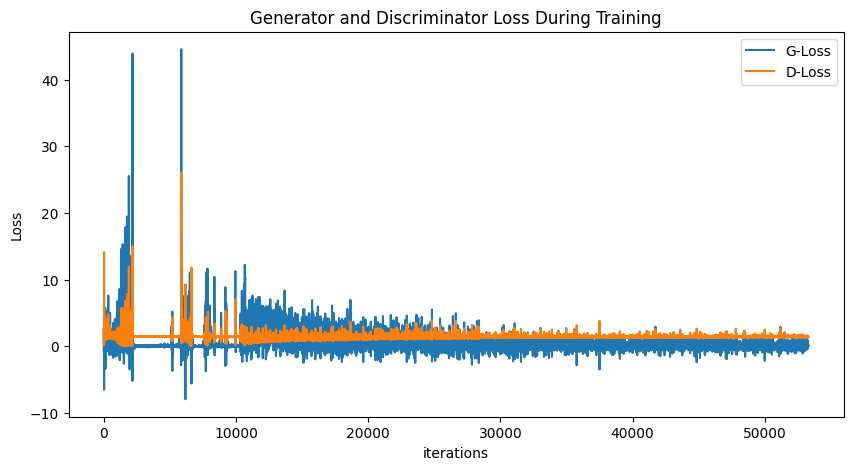

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_G,label="G-Loss")
plt.plot(losses_D,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
gan.save_generator("./model")

In [21]:
gan.G.eval()
gan.G(torch.randn(32, noise_dim, device=device))

tensor([[-0.2243, -0.1327, -0.2232,  ..., -0.2339, -0.2425,  0.0375],
        [-0.0986, -0.1800, -0.2127,  ..., -0.1870, -0.2596, -0.2632],
        [-0.2182, -0.1725, -0.1684,  ..., -0.0312, -0.2057, -0.1526],
        ...,
        [-0.5223, -0.6173, -0.6085,  ..., -0.3052, -0.6795, -0.1333],
        [-0.0774, -0.2506, -0.0868,  ..., -0.0088, -0.1617, -0.1191],
        [-0.2903, -0.1821, -0.2356,  ..., -0.3012, -0.3785,  0.1578]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [12]:
normalized_predictions = gan.predict(2, device)
print(normalized_predictions.min())
boundary = int(len(tokenizer) / 2)
predictions = [x * boundary + boundary for x in normalized_predictions]
predictions[0]

-0.49955088


array([329.51785, 319.92444, 365.87177, 284.88153, 310.37024, 349.19165,
       286.2045 , 326.48254, 310.00046, 278.8695 , 345.87128, 322.52747,
       368.29132, 326.4068 , 425.5765 , 324.88312, 363.78275, 348.98987,
       330.53076, 294.71405, 455.52582, 350.5382 , 353.30124, 363.04126,
       368.16394, 327.60083, 284.92285, 335.45172, 367.8002 , 361.6862 ,
       397.364  , 450.93182, 335.68436, 391.40295, 352.33078, 333.95428,
       344.67227, 324.6883 , 367.9865 , 384.566  , 319.26544, 345.35886,
       311.0888 , 318.03177, 301.25494, 366.396  , 339.03436, 312.2528 ,
       341.71634, 399.09906, 286.3581 , 359.20572, 257.19626, 363.5097 ,
       352.98608, 314.9967 , 379.49762, 367.49884, 314.17087, 345.18134,
       373.84003, 286.19583, 415.6866 , 313.83276, 298.09564, 397.87646,
       336.46454, 425.20007, 342.73138, 411.86115, 312.69775, 320.839  ,
       353.81793, 346.09766, 390.44305, 366.6177 , 306.17773, 361.99042,
       362.7445 , 311.34232, 398.03372, 326.31143, 

In [30]:
n_generations = 5
base_name = "generated"

gan.generate(
    n                 = n_generations,
    base_output_name  = base_name, 
    device            = device,
)

In [35]:
display_audio(f"{base_name}_4.mid")

In [20]:
gan2 = torch.load("./model")

<ipython-input-20-fbaf6b764102>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan2 = torch.load("./model")


In [ ]:
from IPython.display import FileLink
FileLink(r'generated.mid')